<a href="https://colab.research.google.com/github/patrickherbeth/LODWEB/blob/master/BPI_Challenge_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sobre o conjunto de dados


---


Este registro de eventos pertence a um processo de solicitação de empréstimo de um instituto financeiro holandês. Os dados contemplam todos os pedidos protocolados em sistema online no ano de 2016 e seus eventos subsequentes até 1º de fevereiro de 2017, 15h11. A empresa que fornece os dados e o processo em consideração é a mesma que doi: 10.4121 / uuid: 3926db30-f712-4394-aebc-75976070e91f. No entanto, o sistema de suporte do processo mudou nesse meio tempo. Em particular, o sistema agora permite várias ofertas por aplicativo. Essas ofertas podem ser rastreadas por meio de seus IDs no log.

Os dados são fornecidos em dois arquivos:

O log de eventos do aplicativo. Este log de eventos contém todos os eventos com o aplicativo como o ID do caso. Qualquer evento relacionado a uma oferta também se refere a um OfferID.

O log de eventos da oferta. Este log de eventos contém todos os eventos relacionados a ofertas, com essas ofertas como ID de caso. Para cada oferta, um aplicativo correspondente está disponível.

#Análise

**Importando bibliotecas**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from google.colab import drive

%matplotlib inline

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Importando dados do log de eventos do aplicativo**

In [1]:
#drive.mount('/content/drive')
#application_df = pd.read_csv('/content/drive/My Drive/content/BPI_Challenge_2017.csv')

application_df = pd.read_csv('BPI_Challenge_2017.csv')

NameError: ignored

**Rápida olhada nos Dados**

In [ ]:
application_df.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,AcceptedLoan
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


**Tipos de Dados das colunas**

In [ ]:
application_df.dtypes

Action                    object
org:resource              object
concept:name              object
EventOrigin               object
EventID                   object
lifecycle:transition      object
time:timestamp            object
case:LoanGoal             object
case:ApplicationType      object
case:concept:name         object
case:RequestedAmount     float64
FirstWithdrawalAmount    float64
NumberOfTerms            float64
Accepted                  object
MonthlyCost              float64
Selected                  object
CreditScore              float64
OfferedAmount            float64
OfferID                   object
dtype: object

In [ ]:
application_df.describe()

,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,MonthlyCost,CreditScore,OfferedAmount
count,1.202267e+06,42995.000000,42995.000000,42995.000000,42995.000000,42995.000000
mean,1.675947e+04,8394.338979,83.041982,281.403309,318.645912,18513.719940
std,1.572320e+04,10852.443358,36.386199,192.577735,433.706216,13718.507416
min,0.000000e+00,0.000000,5.000000,43.050000,0.000000,5000.000000
25%,6.000000e+03,0.000000,56.000000,152.820000,0.000000,8800.000000
50%,1.400000e+04,5000.000000,77.000000,244.520000,0.000000,15000.000000
75%,2.300000e+04,12000.000000,120.000000,350.000000,848.000000,25000.000000
max,4.500000e+05,75000.000000,180.000000,6673.830000,1145.000000,75000.000000


# Análise exploratória dos dados

I - Qual o objetivo do pedido de empréstimo (**LoanGoal**) mais comum em cada mês do ano? (Carro, melhora na casa, etc.) 

Inicialmente, verificando qual o pedido de empréstimo mais comum no geral

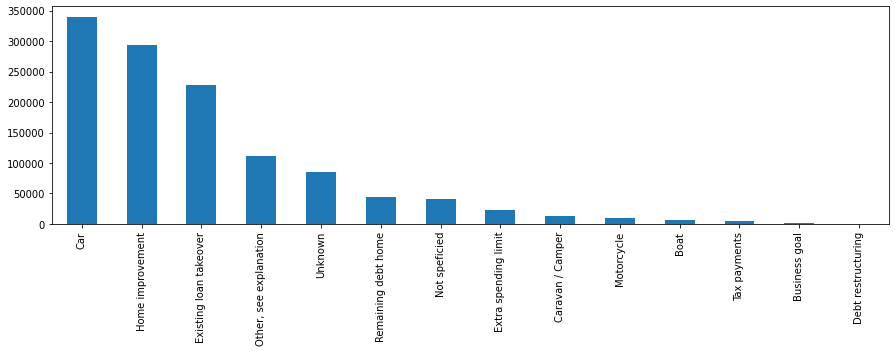

In [ ]:
application_df['case:LoanGoal'].value_counts().plot(figsize=(15, 4), kind='bar')

Verificando o objetivo de pedido de empréstimo mais comum por mês

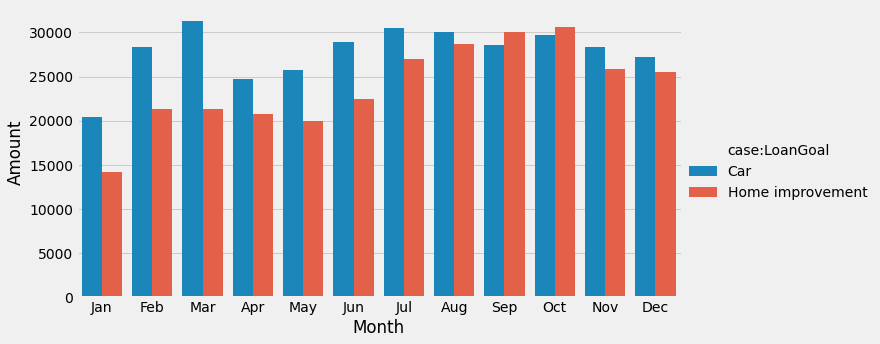

In [ ]:
copy_df = application_df[['time:timestamp', 'case:LoanGoal']].copy(deep=True)
copy_df = copy_df[copy_df['time:timestamp'].str[0:4] != '2017']
copy_df['Month'] = copy_df['time:timestamp'].str[5:7].astype('int')

grouped_df = copy_df.groupby(['Month', 'case:LoanGoal']).count()
grouped_df.rename(columns={'time:timestamp': 'Amount', 'case:LoanGoal': 'LoanGoal'}, inplace=True)
grouped_df.sort_values(['Month','Amount'], ascending=False, inplace=True)
grouped_df.reset_index(inplace=True)

most_commons_loan_goal = grouped_df.groupby('Month').nth((0,1))
most_commons_loan_goal = most_commons_loan_goal.reset_index()
most_commons_loan_goal['Month'] = most_commons_loan_goal['Month'].map(lambda Month: calendar.month_abbr[Month])

sns.catplot(x='Month', y='Amount', hue='case:LoanGoal', hue_order=['Car', 'Home improvement'], data=most_commons_loan_goal, kind='bar', aspect=2)

II - Qual a média do valor do empréstimo pra cada um dos objetivos de empréstimo?

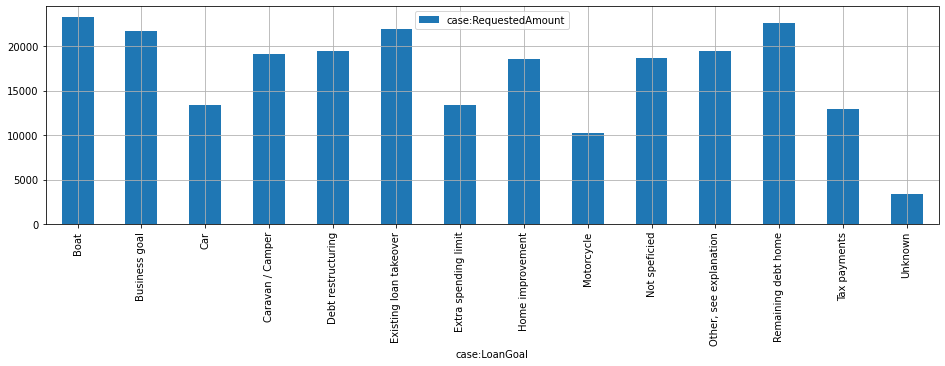

In [ ]:
base_media = application_df.groupby(["case:LoanGoal"]).mean()[["case:RequestedAmount"]]

base_media.plot.bar(figsize=(16, 4), grid=True)

#Análise Preditiva

I - Predição do valor da oferta a ser recebida (Regressão Linear Múltipla)

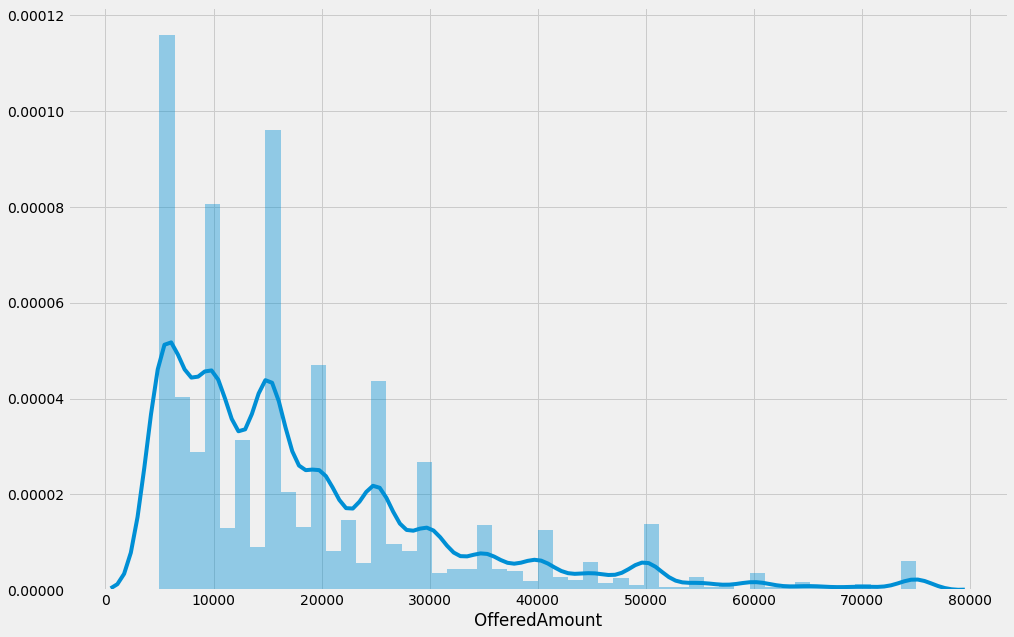

In [ ]:
copy_df = application_df[['case:LoanGoal', 'case:RequestedAmount', 'case:ApplicationType', 'OfferedAmount']].copy(deep=True)
copy_df.rename(columns={'case:LoanGoal': 'LoanGoal', 'case:RequestedAmount': 'RequestedAmount', 'case:ApplicationType':'ApplicationType'}, inplace=True)

## enconding LoanGoal column
encoder = OneHotEncoder()
encoded_df_loan_goal = pd.DataFrame(encoder.fit_transform(copy_df[['LoanGoal']]).toarray())
encoded_df_loan_goal.columns = encoder.get_feature_names(['LoanGoal'])

# enconding ApplicationType column
encoded_df_app_type = pd.DataFrame(encoder.fit_transform(copy_df[['ApplicationType']]).toarray())
encoded_df_app_type.columns = encoder.get_feature_names(['ApplicationType'])

# removing original categorical columns
copy_df.drop(['LoanGoal', 'ApplicationType'], axis = 1, inplace = True)

# concating the generated DataFrames with the original
copy_df = pd.concat([copy_df, encoded_df_loan_goal, encoded_df_app_type], axis = 1)

copy_df.dropna(inplace=True)

x = copy_df[['RequestedAmount', 'LoanGoal_Boat',
       'LoanGoal_Business goal', 'LoanGoal_Car', 'LoanGoal_Caravan / Camper',
       'LoanGoal_Debt restructuring', 'LoanGoal_Existing loan takeover',
       'LoanGoal_Extra spending limit', 'LoanGoal_Home improvement',
       'LoanGoal_Motorcycle', 'LoanGoal_Not speficied',
       'LoanGoal_Other, see explanation', 'LoanGoal_Remaining debt home',
       'LoanGoal_Tax payments', 'LoanGoal_Unknown',
       'ApplicationType_Limit raise', 'ApplicationType_New credit']].values

y = copy_df['OfferedAmount'].values

plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(application_df['OfferedAmount'])

#splitting data in train and test (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

#training the model
regressor = LinearRegression()  
regressor.fit(x_train, y_train)

#prediction on test data
y_pred = regressor.predict(x_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)

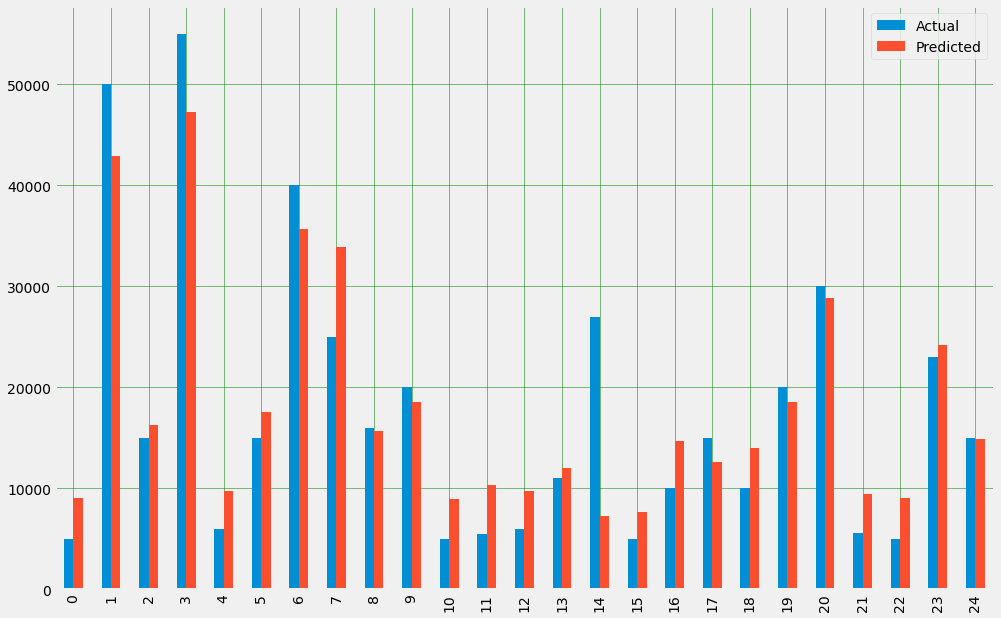

Mean Absolute Error: 4649.121115333006
Root Mean Squared Error: 9278.063887789107


In [ ]:
# Plotting chart with the diff between the predction and actual values
df1.plot(kind='bar',figsize=(15,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Calculating some metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
df1

,Actual,Predicted
0,5000.0,9024.068621
1,50000.0,42929.975440
2,15000.0,16236.823018
3,55000.0,47243.401262
4,6000.0,9747.548999
5,15000.0,17608.162207
6,40000.0,35695.171659
7,25000.0,33886.470714
8,16000.0,15648.913463
9,20000.0,18542.834975


II - Predizer quais aplicações vão receber uma oferta (Classificação) 

In [ ]:
# getting the registers of applications that contain A_Pending in their event log 
accepted_loans = application_df[application_df['concept:name'] == 'A_Pending']
accpeteds_application_names = accepted_loans['case:concept:name'].unique()

# creating new column indicating if the application loan was successfull or not
application_df['AcceptedLoan'] = application_df['case:concept:name'].isin(accpeteds_application_names).astype(int)
application_df

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,AcceptedLoan
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1580299144,0


In [ ]:
copy_df = application_df[['case:RequestedAmount', 'case:LoanGoal', 'case:ApplicationType', 'AcceptedLoan', 'Selected', 'Accepted', 'CreditScore']].copy(deep=True)

copy_df.dropna(inplace=True)

copy_df.drop_duplicates(inplace=True)

x = copy_df[['case:RequestedAmount', 'CreditScore']].values
y = copy_df['AcceptedLoan'].values

copy_df

,case:RequestedAmount,case:LoanGoal,case:ApplicationType,AcceptedLoan,Selected,Accepted,CreditScore
9,20000.0,Existing loan takeover,New credit,1,True,True,979.0
50,10000.0,Home improvement,New credit,0,False,False,0.0
79,15000.0,Home improvement,New credit,1,False,True,0.0
87,15000.0,Home improvement,New credit,1,True,True,1059.0
135,5000.0,Car,New credit,1,False,False,0.0
...,...,...,...,...,...,...,...
1201901,25000.0,Not speficied,New credit,1,True,True,903.0
1202007,16000.0,Car,New credit,1,True,True,941.0
1202075,5000.0,Car,New credit,1,True,True,852.0
1202148,10000.0,Home improvement,New credit,1,True,True,854.0


In [ ]:
#splitting data in train and test sets (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)

#Train the model using 
clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)

print('Accuracy on training set: {:.2f}'.format(clf.score(x_train, y_train)))
print('Accuracy on test set: {:.2f}'.format(clf.score(x_test, y_test)))


Accuracy on training set: 0.91
Accuracy on test set: 0.88


In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Text(0.5, 1.0, 'Feature Importances')

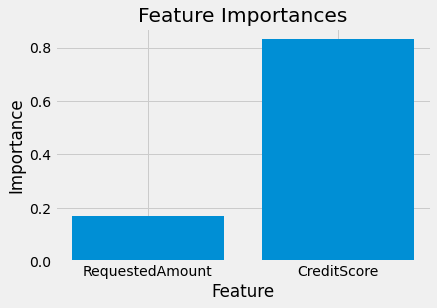

In [ ]:
feature_list = ['RequestedAmount', 'CreditScore']
feature_imp = pd.Series(clf.feature_importances_,index=feature_list)

plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_imp)))
plt.bar(x_values, feature_imp, orientation = 'vertical')
plt.xticks(x_values, feature_list)

plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances')